Before launching the code make sure to have all the releavant requirments and modules  
Be also sure to have set up the Pg database using the .sql file, and change the credetientals to match your own

In [ ]:
from utils import scrape_news, clean_html, preprocess_text, calculate_sentiment
from db import add_stock, add_daily_price, add_news_data, get_stock_prices, get_article_sentiment, init_db, save_database_to_csv
import yfinance as yf
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt

# Data Collection and Preprocessing 

We start by collecting and preprocessing the relevant data.

In [2]:
#We input a symbol and get the stock data and news data of the last 30 days

ticker = 'AAPL'

raw_stock_data = yf.download(ticker, period= '1mo', interval= "1d", multi_level_index= False, auto_adjust= True)
raw_news_data = pd.DataFrame.from_dict(scrape_news(ticker))
raw_news_data = clean_html(raw_news_data)
news_data = preprocess_text(raw_news_data)
stock_data = raw_stock_data.reset_index()

[*********************100%***********************]  1 of 1 completed


We check the 5 first entries to see if everything works fine

In [3]:
news_data.head(5)

,title,ticker,publish_date,link
0,whi appl ’ s stock is beat the market even as ...,AAPL,2025-11-18 22:54:00,https://news.google.com/rss/articles/CBMitANBV...
1,appl is appar get readi to replac ceo tim cook...,AAPL,2025-11-18 19:51:04,https://news.google.com/rss/articles/CBMijAFBV...
2,qubt stock vs. aapl stock ? - forb,AAPL,2025-11-18 15:08:49,https://news.google.com/rss/articles/CBMiiwFBV...
3,appl ( aapl ) : new sell recommend for thi tec...,AAPL,2025-11-19 09:00:38,https://news.google.com/rss/articles/CBMi3wFBV...
4,report say appl ( aapl ) ceo tim cook could st...,AAPL,2025-11-17 16:52:10,https://news.google.com/rss/articles/CBMiogFBV...


In [4]:
stock_data.head(5)

,Date,Close,High,Low,Open,Volume
0,2025-10-20,261.986023,264.123965,255.382439,255.642182,90483000
1,2025-10-21,262.515503,265.033082,261.576411,261.626381,46695900
2,2025-10-22,258.199707,262.595440,255.182612,262.395621,45015300
3,2025-10-23,259.328583,260.367584,257.760126,259.688250,32754900
4,2025-10-24,262.565491,263.874220,258.929001,260.937064,38253700


# Sentiment analysis

We calculate the sentiment score for our news data, using VADER.  
Here is a table explaining the meaning behind the value of the compound sentiment score, which is used for sentiment analysis here

| Compound score             | Interpreted sentiment |
| -------------------------- | --------------------- |
| `≥ 0.05`                   | **Positive** 😊       |
| `≤ -0.05`                  | **Negative** 😞       |
| Between `-0.05` and `0.05` | **Neutral** 😐        |


In [5]:
news_data = calculate_sentiment(news_data)


We then feed the data to our database. 
- the database is built on pgadmin4.
- Make sure to have it running before interacting with it. 

In [6]:
#We initiate the database (check if it exists, if not create it) and feed the data into the database
init_db()


#We feed the data into the database
add_stock(ticker)
add_daily_price(ticker, stock_data)
add_news_data(ticker, news_data)

If we desire we can recover the database data as a csv to use the data for training purposes.

In [7]:
stock_df, article_df = save_database_to_csv()
stock_df.to_csv('stock_data.csv', index= False)
article_df.to_csv('article_data.csv', index= False)

## Generate information


We start by computing each day average news sentiment we have for a specific stock.  
We can adjust with date spans if we want (and as we get more and more data into our database), but as I have almost no data now, I decided to use everything I have to look at the correlation between price and news.

In [8]:

#We query the database to get the information we need for the correlation analysis
prices = get_stock_prices(ticker)
sentiment = get_article_sentiment(ticker)

sentiment_daily = (
    sentiment.groupby(pd.to_datetime(sentiment['publish_date']).dt.date)['compound_sentiment_score']
    .mean()
    .reset_index()
    .rename(columns={"publish_date": "date", "compound_sentiment_score": "avg_sentiment"})
)

sentiment_daily.head()

,date,avg_sentiment
0,2025-07-14,0.0000
1,2025-07-30,0.0000
2,2025-08-13,0.5267
3,2025-08-17,0.0000
4,2025-08-29,0.5106


In [10]:
prices['date'] = pd.to_datetime(prices['date'])
sentiment_daily['date'] = pd.to_datetime(sentiment_daily['date'])


#We build the plotting dataframe
merged_prices_sent = pd.merge(prices, sentiment_daily, on="date", how="left")
merged_prices_sent['avg_sentiment'] = merged_prices_sent['avg_sentiment'].fillna(0)

#We standardize the price and sentiment columns using z-score normalization
#Without this we cannot compare the two metrics directly as they are on different scales
merged_prices_sent['price_z'] = zscore(merged_prices_sent['close'])
merged_prices_sent['sent_z'] = zscore(merged_prices_sent['avg_sentiment'])
merged_prices_sent.head(30)

ValueError: unconverted data remains when parsing with format "%Y-%m-%dT%H:%M:%S": "+00:00", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
merged_prices_sent['avg_sentiment'].value_counts().head(10)
print(merged_prices_sent['avg_sentiment'].describe())
print(sentiment_daily['avg_sentiment'].describe())


count    156.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: avg_sentiment, dtype: float64
count    42.000000
mean      0.122763
std       0.190893
min      -0.125000
25%       0.000000
50%       0.000000
75%       0.243563
max       0.526700
Name: avg_sentiment, dtype: float64


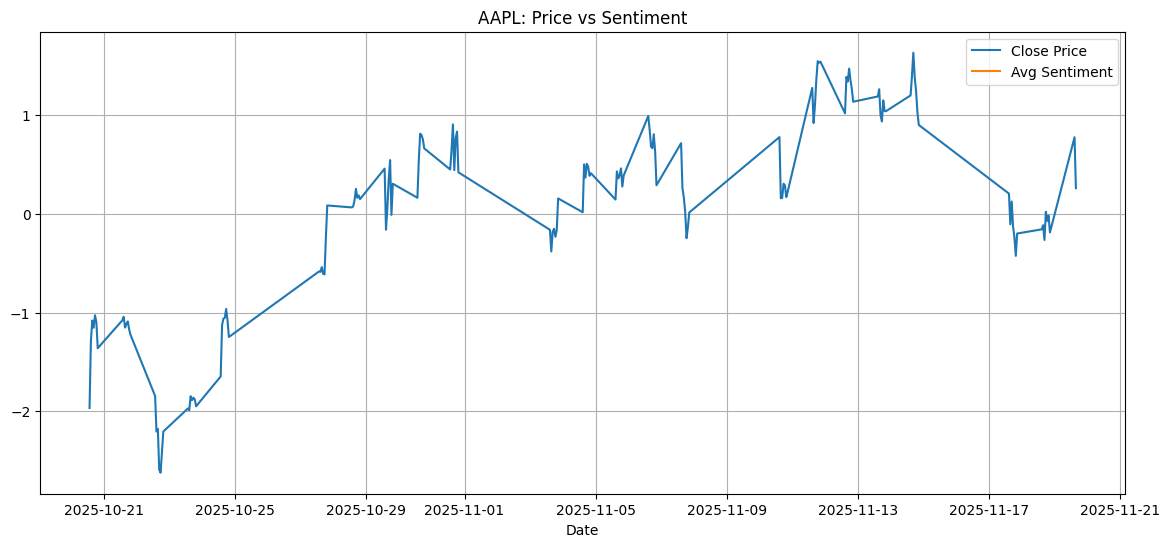

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(merged_prices_sent['date'], merged_prices_sent['price_z'], label='Close Price')
plt.plot(merged_prices_sent['date'], merged_prices_sent['sent_z'], label='Avg Sentiment')

plt.title(f"{ticker}: Price vs Sentiment")
plt.xlabel("Date")
plt.legend()
plt.grid()
plt.show()